In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import STOPWORDS
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb

In [2]:
train=pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')
sample_submission=pd.read_csv('./data/sample_submission.csv')

## Data exploration

In [3]:
print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train['text_raw']=train.text.copy()

In [5]:
print(f'Number of real/Not disasters: {train.target.value_counts()[0]}/{train.target.value_counts()[1]}')
print(f'Number of unique values in keyword : {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'keyword na_values:{train[train.location.isnull()].shape[0]}(train)/{test[test.location.isnull()].shape[0]}(test)')
print(f'train中不同tweet数目：{train.text.nunique()}/总数目：{train.text.shape[0]}')
      
ununiqueTextTrain=train.text.value_counts().to_frame()
print(f'出现两次以上的tweet有{ununiqueTextTrain[ununiqueTextTrain.text>1].shape[0]}条/出现总次数：{ununiqueTextTrain[ununiqueTextTrain.text>1].sum().text}次')

Number of real/Not disasters: 4342/3271
Number of unique values in keyword : 221 (Training) - 221 (Test)
keyword na_values:2533(train)/1105(test)
train中不同tweet数目：7503/总数目：7613
出现两次以上的tweet有69条/出现总次数：179次


In [6]:
df_mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
# df_mislabeled.index.tolist()

In [7]:
#部分train数据是重复的，但是target是不一致的，手动修改target标签
train['target_relabeled'] = train['target'].copy() 

train.loc[train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train.loc[train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train.loc[train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train.loc[train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train.loc[train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train.loc[train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train.loc[train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
train.loc[train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
train.loc[train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train.loc[train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train.loc[train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
train.loc[train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
train.loc[train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
train.loc[train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train.loc[train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
train.loc[train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
train.loc[train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
train.loc[train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

In [8]:
df_mislabeled = train.groupby(['text']).nunique().sort_values(by='target_relabeled', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target_relabeled'] > 1]['target_relabeled']
df_mislabeled

Series([], Name: target_relabeled, dtype: int64)

In [9]:
train.head()

,id,keyword,location,text,target,text_raw,target_relabeled
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train.keyword.nunique()

221

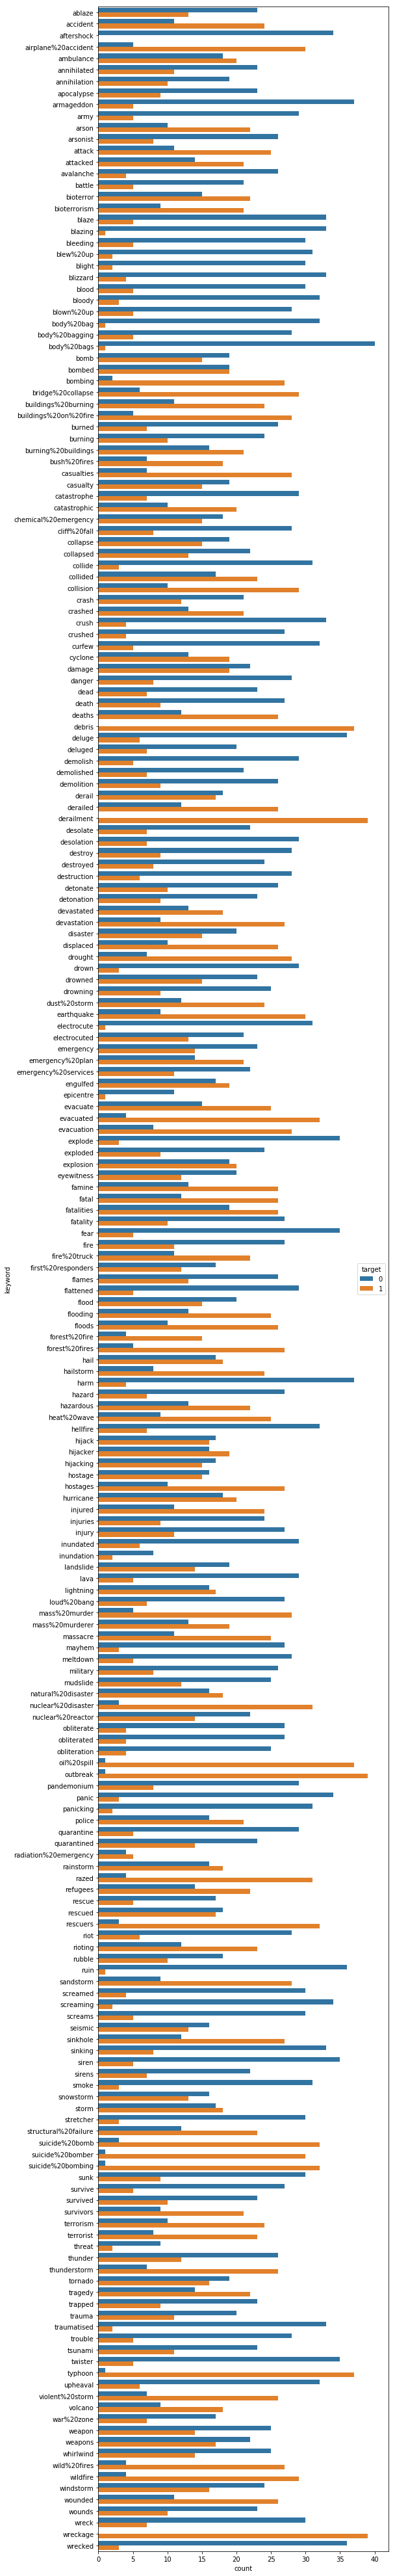

In [11]:
fig = plt.figure(figsize=(8, 72))
sns.countplot(y="keyword", hue="target", data=train)

In [12]:
print(test.shape)
test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
print(sample_submission.shape)
sample_submission.head(3)

(3263, 2)


,id,target
0,0,0
1,2,0
2,3,0


### Data Cleaning

##### 增加features

 word_count number of words in text

unique_word_count number of unique words in text

stop_word_count number of stop words in text

url_count number of urls in text

mean_word_length average character count in words

char_count number of characters in text

punctuation_count number of punctuations in text

hashtag_count number of hashtags (#) in text

mention_count number of mentions (@) in text

In [14]:


train['word_count']=train['text'].apply(lambda x: len(str(x).split()))
test['word_count']=test['text'].apply(lambda x: len(str(x).split()))

train["unique_word_count"]=train['text'].apply(lambda x: len(set(str(x).split())))
test["unique_word_count"]=test['text'].apply(lambda x: len(set(str(x).split())))


train['stop_word_count']=train['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in STOPWORDS]))
test['stop_word_count']=test['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in STOPWORDS]))

train['url_count']=train['text'].apply(lambda x:len([word for word in str(x).lower().split() if 'http' in word or "https" in word]))
test['url_count']=test['text'].apply(lambda x:len([word for word in str(x).lower().split() if 'http' in word or "https" in word]))

train['mean_word_length']=train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length']=test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

train['char_count']=train['text'].apply(lambda x: len(str(x)))
test['char_count']=test['text'].apply(lambda x: len(str(x)))

train['punctuation_count']=train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count']=test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

train['hashtag_count']=train['text'].apply(lambda x: len([c for c in str(x) if c=="#"]))
test['hashtag_count']=test['text'].apply(lambda x: len([c for c in str(x) if c=="#"]))

train['mention_count']=train['text'].apply(lambda x: len([c for c in str(x) if c=="@"]))
test['mention_count']=test['text'].apply(lambda x: len([c for c in str(x) if c=="@"]))

# Count of uppercase letters
train['caps_count'] = train['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
test['caps_count'] = test['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
# Ratio of uppercase letters
train['caps_ratio'] = train['caps_count'] / train['char_count']
test['caps_ratio'] = test['caps_count'] / test['char_count']

In [15]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'
    #re.finditer:返回string中所有与pattern相匹配的全部字串，返回形式为迭代器
def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    
    
  
    return df
    
train = process_text(train)
test = process_text(test)

In [16]:
train.corr()['target_relabeled'].drop('target_relabeled').sort_values()

stop_word_count     -0.114801
mention_count       -0.101787
caps_ratio           0.021125
word_count           0.038263
unique_word_count    0.051644
hashtag_count        0.055092
id                   0.061273
caps_count           0.082252
punctuation_count    0.135032
mean_word_length     0.179245
char_count           0.182147
url_count            0.199319
target               0.993570
Name: target_relabeled, dtype: float64

In [17]:
train.text_raw.str.contains("RT").value_counts()

False    7460
True      153
Name: text_raw, dtype: int64

In [18]:
train.tail()

,id,keyword,location,text,target,text_raw,target_relabeled,word_count,unique_word_count,stop_word_count,...,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,caps_count,caps_ratio,hashtags,mentions,links
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,1,11,11,2,...,6.636364,83,5,0,0,7,0.084337,no,no,http://t.co/STfMbbZFB5
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,1,20,17,9,...,5.300000,125,5,0,2,6,0.048000,no,aria_ahrary TheTawniest,no
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,8,1,...,7.250000,65,11,0,0,10,0.153846,no,no,http://t.co/zDtoyd8EbJ
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,1,19,19,5,...,6.263158,137,5,0,0,4,0.029197,no,no,no
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,The Latest: More Homes Razed by Northern Calif...,1,13,13,3,...,6.307692,94,7,0,0,16,0.170213,no,no,http://t.co/YmY4rSkQ3d


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


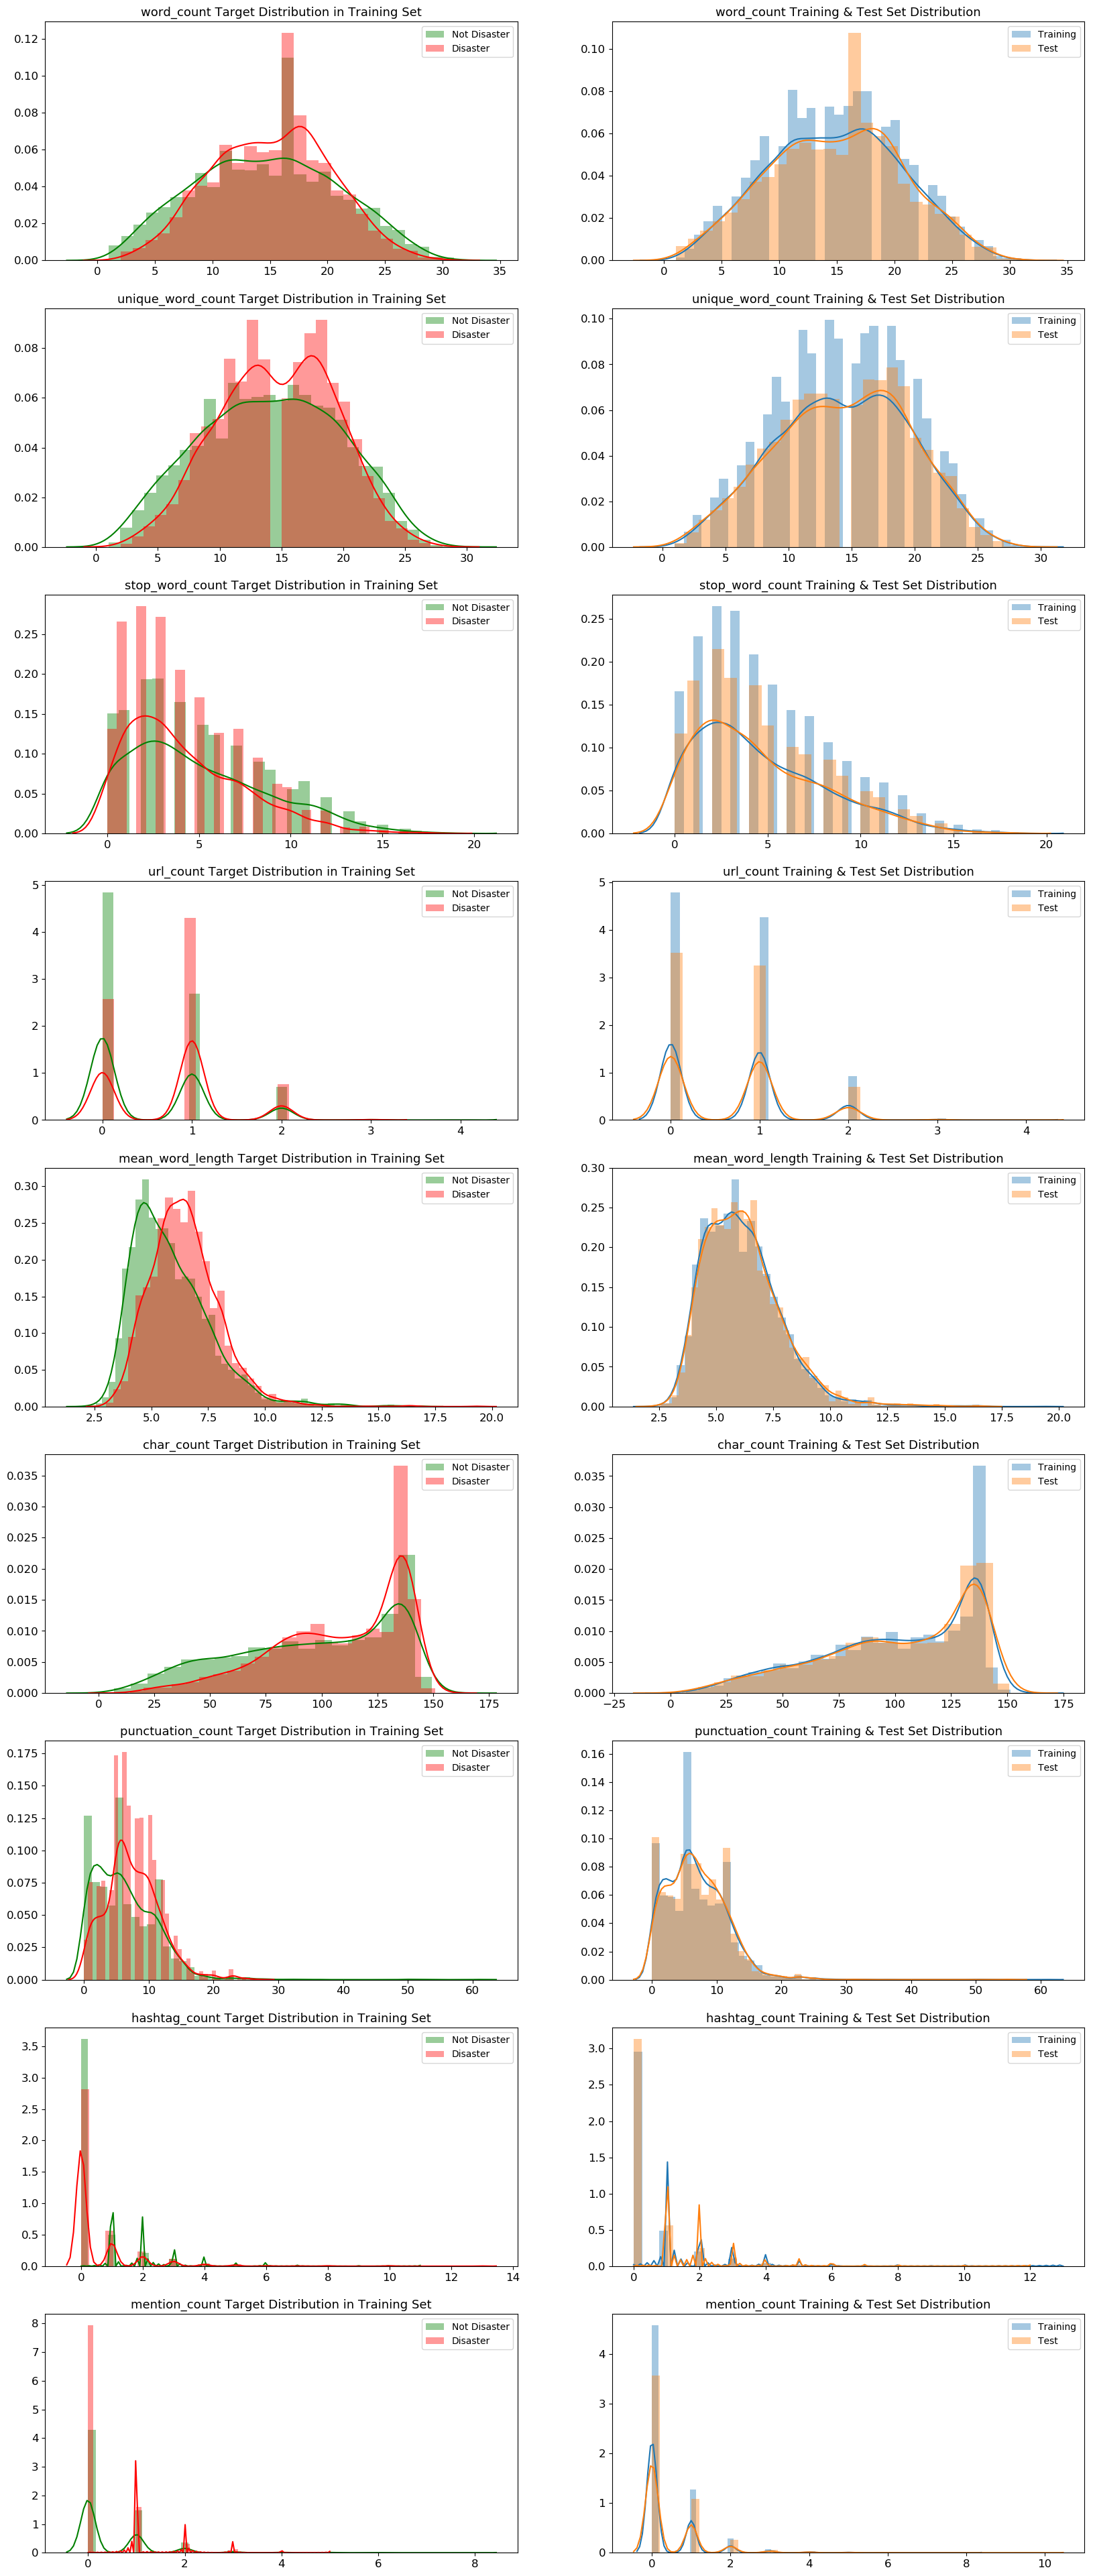

In [ ]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train[feature], label='Training', ax=axes[i][1])
    sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

###### Text Cleaning¶
Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.

The most common type of words that require cleaning in oov have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations #, @, !, ?, +, &, -, $, =, <, >, |, {, }, ^, ', (, ),[, ], *, %, ..., ', ., :, ; are separated from words

Special characters that are attached to words are removed completely单词中的特殊字符

Contractions are expanded
    eg：tweet = re.sub(r"he's", "he is", tweet)

Urls are removed链接网址要去掉

Character entity references are replaced with their actual symbols字符实体参考？

Typos（拼写错误） and slang（俚语） are corrected, and informal abbreviations（非正式的缩写） are written in their long forms 

Some words are replaced with their acronyms（首字母缩略词） and some words are grouped into one

Finally, hashtags（标签#） and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run clean function after adding those replace calls.

In [ ]:
def remove_URL_hashtag_mention(text):
    text=re.sub(r'https?://\S+|www\.\S+','',text)
    text=re.sub(r"#\w+\s+",'',text)
    text=re.sub(r"@\w+\s+",'',text)
    return text
#     url = re.compile(r'https?://\S+|www\.\S+')
#     return url.sub(r'',text)
train['text']=train.text.apply(lambda x: remove_URL_hashtag_mention(str(x)))
test['text']=test.text.apply(lambda x: remove_URL_hashtag_mention(str(x)))

In [ ]:
%%time
# %load tweetclean.py
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"FYI", "for your information", tweet)
    tweet = re.sub(r"U.S", "USA", tweet) 
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    tweet = re.sub(r'\n',' ', tweet) # Remove line breaks
    tweet = re.sub('\s+', ' ', tweet).strip() # Remove leading, trailing, and extra spaces
    

    
    return tweet
train['text'] = train['text'].apply(lambda s : clean(s))
test['text'] = test['text'].apply(lambda s : clean(s))

Wall time: 7min 2s


In [ ]:
train.head(30)

,id,keyword,location,text,target,text_raw,target_relabeled,word_count,unique_word_count,stop_word_count,...,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,caps_count,caps_ratio,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this May ALLAH For...,1,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,...,4.384615,69,1,1,0,10,0.144928,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1,Forest fire near La Ronge Sask. Canada,1,7,7,0,...,4.571429,38,1,0,0,5,0.131579,no,no,no
2,5,NaN,NaN,All residents asked to ' shelter in place ' ar...,1,All residents asked to 'shelter in place' are ...,1,22,20,11,...,5.090909,133,3,0,0,2,0.015038,no,no,no
3,6,NaN,NaN,"13,000 people receive evacuation orders in Cal...",1,"13,000 people receive #wildfires evacuation or...",1,8,8,1,...,7.125000,65,2,1,0,1,0.015385,wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby as smoke fr...,1,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,...,4.500000,88,2,2,0,3,0.034091,Alaska wildfires,no,no
5,8,NaN,NaN,Update = > California Hwy . 20 closed in both ...,1,#RockyFire Update => California Hwy. 20 closed...,1,18,18,3,...,5.166667,110,7,3,0,9,0.081818,RockyFire CAfire wildfires,no,no
6,10,NaN,NaN,Heavy rain causes flash flooding of streets in...,1,#flood #disaster Heavy rain causes flash flood...,1,14,14,2,...,5.857143,95,3,2,0,4,0.042105,flood disaster,no,no
7,13,NaN,NaN,I am on top of the hill and I can see a fire i...,1,I'm on top of the hill and I can see a fire in...,1,15,14,10,...,3.000000,59,4,0,0,2,0.033898,no,no,no
8,14,NaN,NaN,There is an emergency evacuation happening now...,1,There's an emergency evacuation happening now ...,1,12,11,5,...,5.666667,79,1,0,0,1,0.012658,no,no,no
9,15,NaN,NaN,I am afraid that the tornado is coming to our ...,1,I'm afraid that the tornado is coming to our a...,1,10,10,6,...,4.300000,52,4,0,0,1,0.019231,no,no,no


In [ ]:
#把关键词放到文本中考虑
# train['text']=train['keyword'].str.cat(train['text'],join='left',sep=" ",na_rep="")
# test['text']=test['keyword'].str.cat(test['text'],join='left',sep=" ",na_rep="")#把关键词考虑进来

In [ ]:
# 去除标点符号
train['text'] =train['text'] .apply(lambda x:x.translate(str.maketrans('', '', string.punctuation)))
test['text'] =test['text'] .apply(lambda x:x.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
# 统一小写
train['text']=train['text'].apply(lambda x: x.lower())
test['text']=test['text'].apply(lambda x: x.lower())

In [ ]:
# 词干处理
english_stemmer = nltk.stem.SnowballStemmer("english")
# print(english_stemmer.stem(train['text'].iloc[0]))
train['text']=train['text'].apply(lambda x:english_stemmer.stem(x))
test['text']=test['text'].apply(lambda x: english_stemmer.stem(x))


In [ ]:
train['text'][0]

'our deeds are the reason of this may allah forgive us al'

In [ ]:
train.head()

,id,keyword,location,text,target,text_raw,target_relabeled,word_count,unique_word_count,stop_word_count,...,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,caps_count,caps_ratio,hashtags,mentions,links
0,1,NaN,NaN,our deeds are the reason of this may allah for...,1,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,...,4.384615,69,1,1,0,10,0.144928,earthquake,no,no
1,4,NaN,NaN,forest fire near la ronge sask canada,1,Forest fire near La Ronge Sask. Canada,1,7,7,0,...,4.571429,38,1,0,0,5,0.131579,no,no,no
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,All residents asked to 'shelter in place' are ...,1,22,20,11,...,5.090909,133,3,0,0,2,0.015038,no,no,no
3,6,NaN,NaN,13000 people receive evacuation orders in cali...,1,"13,000 people receive #wildfires evacuation or...",1,8,8,1,...,7.125000,65,2,1,0,1,0.015385,wildfires,no,no
4,7,NaN,NaN,just got sent this photo from ruby as smoke fr...,1,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,...,4.500000,88,2,2,0,3,0.034091,Alaska wildfires,no,no


In [ ]:
train.to_csv('train_clean.csv')

In [ ]:
test.to_csv('test_clean.csv')

## model

In [ ]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_raw',
       'target_relabeled', 'word_count', 'unique_word_count',
       'stop_word_count', 'url_count', 'mean_word_length', 'char_count',
       'punctuation_count', 'hashtag_count', 'mention_count', 'caps_count',
       'caps_ratio', 'hashtags', 'mentions', 'links'],
      dtype='object')

In [ ]:
y_train = train.target_relabeled
train_raw=train.loc[:,['text_raw','target_relabeled', 'target']]
train.drop(columns = ['text_raw','target_relabeled', 'target'],inplace=True)

In [ ]:
#处理keyword的空值，否则CountVectorizer会有问题,后面用了one-hot编码
train['keyword'].fillna("no",inplace=True)
test['keyword'].fillna("no",inplace=True)

In [ ]:
train.keyword.isna().value_counts()

False    7613
Name: keyword, dtype: int64

In [ ]:
# 增加其他特征
from sklearn.feature_extraction.text import CountVectorizer

#keyword one-hot编码

# X_train_keyword=pd.get_dummies(train.keyword,prefix='keyword_')
# X_test_keyword=pd.get_dummies(test.keyword,prefix='keyword_')
keywordEnc=OneHotEncoder()
# keywordEnc=OneHotEncoder.fit(train.keyword)
X_train_keyword_enc=keywordEnc.fit_transform(train.keyword.values.reshape(-1, 1))
X_test_keyword_enc=keywordEnc.transform(test.keyword.values.reshape(-1, 1))
X_train_keyword=pd.DataFrame(X_train_keyword_enc.toarray(),columns='keyword_'+keywordEnc.get_feature_names())
X_test_keyword=pd.DataFrame(X_test_keyword_enc.toarray(),columns='keyword_'+keywordEnc.get_feature_names())
# print(keywordEnc.get_feature_names(),'***',keywordEnc.categories_,X_train_keyword.shape,'***',X_test_keyword.shape,"***\n",X_train_keyword.columns)

# url_count
vec_links = CountVectorizer(min_df = 3, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 3)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 3)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print ("训练集：",X_train_keyword.shape,X_train_link.shape, X_train_men.shape, X_train_hash.shape)
print ("测试集：",X_test_keyword.shape,X_test_link.shape, X_test_men.shape, X_test_hash.shape)

训练集： (7613, 222) (7613, 22) (7613, 65) (7613, 250)
测试集： (3263, 222) (3263, 22) (3263, 65) (3263, 250)


In [ ]:
X_train_keyword.columns

Index(['keyword_x0_ablaze', 'keyword_x0_accident', 'keyword_x0_aftershock',
       'keyword_x0_airplane%20accident', 'keyword_x0_ambulance',
       'keyword_x0_annihilated', 'keyword_x0_annihilation',
       'keyword_x0_apocalypse', 'keyword_x0_armageddon', 'keyword_x0_army',
       ...
       'keyword_x0_weapons', 'keyword_x0_whirlwind', 'keyword_x0_wild%20fires',
       'keyword_x0_wildfire', 'keyword_x0_windstorm', 'keyword_x0_wounded',
       'keyword_x0_wounds', 'keyword_x0_wreck', 'keyword_x0_wreckage',
       'keyword_x0_wrecked'],
      dtype='object', length=222)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
english_stemmer=nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer=super(TfidfVectorizer,self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
# vectorizer= StemmedTfidfVectorizer()
#TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(train.text, train.target, test_size = 0.25, random_state = 0)
Tfidf_vect = StemmedTfidfVectorizer(min_df=3,stop_words="english",ngram_range=(1,2))#stop_words="english",ngram_range=(1,3)，加了这个参数f1得分反而低
X_train_vec= Tfidf_vect.fit_transform(train.text)#train[[col for col in train.columns if col not in ['id','keyword','location','target']]]
X_train_text = pd.DataFrame(X_train_vec.toarray(), columns=Tfidf_vect.get_feature_names())

print(f'Tfidf处理后的大小：{X_train_text.shape},{y_train.shape}')

Tfidf处理后的大小：(7613, 5594),(7613,)


In [ ]:
Tfidf_vect.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [ ]:
X_test_vec = Tfidf_vect.transform(test.text)#test[[col for col in test.columns if col not in ['id','keyword','location','target']]]
X_test_text=pd.DataFrame(X_test_vec.toarray(), columns=Tfidf_vect.get_feature_names())
print(f'test数据集Tfidf处理后的大小：{X_test_text.shape}')

test数据集Tfidf处理后的大小：(3263, 5594)


In [ ]:
# error

In [ ]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'word_count', 'unique_word_count',
       'stop_word_count', 'url_count', 'mean_word_length', 'char_count',
       'punctuation_count', 'hashtag_count', 'mention_count', 'caps_count',
       'caps_ratio', 'hashtags', 'mentions', 'links'],
      dtype='object')

In [ ]:
test.columns

Index(['id', 'keyword', 'location', 'text', 'word_count', 'unique_word_count',
       'stop_word_count', 'url_count', 'mean_word_length', 'char_count',
       'punctuation_count', 'hashtag_count', 'mention_count', 'caps_count',
       'caps_ratio', 'hashtags', 'mentions', 'links'],
      dtype='object')

In [ ]:
print('target' in  train.columns,'target' in  test.columns ,'target_text' in  train.columns,'target_text' in  test.columns )

False False False False


In [ ]:
# Joining the dataframes together
train = train.join(X_train_keyword, rsuffix='_keyword')
train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_keyword, rsuffix='_keyword')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)
# X.shape

(7613, 6171) (3263, 6171)


In [ ]:
type(train)

pandas.core.frame.DataFrame

In [ ]:
#利用pipeline建模
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']
features_to_drop=['id', 'keyword', 'location', 'text', 'hashtags','mentions', 'links']
X_train = train.drop(columns = features_to_drop)
X_test = test.drop(columns = features_to_drop)

scaler = MinMaxScaler()


lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
Y_pred = pipeline.predict(X_test)

pipeline.score(X_train, y_train)


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.9094969131748325

In [ ]:
type(X_train)

pandas.core.frame.DataFrame

In [ ]:
from sklearn.metrics import f1_score
print ('Training f1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

Training f1 score: 0.8880


In [ ]:
# submit = sub_sample.copy()
# submit.target = y_test
# submit.to_csv('submit_lr.csv',index=False)
sample_submission["target"]=Y_pred
sample_submission.to_csv("submission_Logistic_lr.csv", index=False)

In [ ]:
train["pred"]=pipeline.predict(X_train)
train['relabeled_target']=y_train
wrongPred=train[train.relabeled_target!=train.pred]

print(f'总共{len(wrongPred)}条预测错误！')
# wrongPred[wrongPred['text'].str.contains("http:")].shape
FP=wrongPred[wrongPred.relabeled_target==1]
print(f'{len(FP)}条真正的disaster预测错误')
FN=wrongPred[wrongPred.relabeled_target==0]
print(f'{len(FN)}条假的disaster预测错误')
wrongPred.to_csv('wrongPred.csv')
wrongPred

总共689条预测错误！
527条真正的disaster预测错误
162条假的disaster预测错误


,id,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,...,zero,zombi,zombie apocalyps,zon,zone,zone com,zouma,zouma just,pred,relabeled_target
7,13,no,NaN,i am on top of the hill and i can see a fire i...,15,14,10,0,3.000000,59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
31,48,ablaze,Birmingham,wholesale markets ablaz,5,5,0,1,10.200000,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
56,80,ablaze,South Africa,truck ablaze r21 voortrekker ave ousaide or...,13,13,1,1,6.538462,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
71,102,accident,"St. Louis, MO",speeding among top causes of teen accidents ca...,14,14,1,2,9.000000,139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
80,117,accident,NaN,mom we did not get home as fast as we wished...,27,25,12,0,4.259259,142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
99,143,accident,NaN,only had a car for not even a week and got in ...,22,18,10,0,3.454545,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
140,201,airplane%20accident,NaN,awwww they are on an airplane accident and the...,17,16,7,0,5.176471,104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
150,215,airplane%20accident,"New Mexico, USA",that or they might be killed in an airplane ac...,22,21,11,0,4.772727,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
166,241,airplane%20accident,Fashion Heaven. IG: TMId_,my phone looks like it was in a car ship airpl...,13,13,6,0,4.307692,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
167,242,airplane%20accident,"San Francisco, CA",statistically i am at more of risk of getting ...,21,19,13,0,4.000000,104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


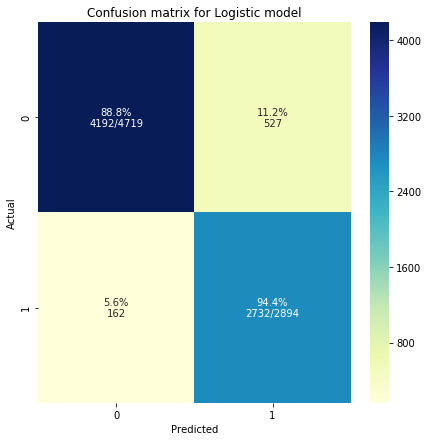

In [ ]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
plot_cm(train['pred'], y_train, 'Confusion matrix for Logistic model', figsize=(7,7))#

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,4192,162
1,527,2732


In [ ]:
# scale = MinMaxScaler()
# X_train=scale.fit_transform(X_train)
# X_test=scale.transform(X_test)

In [ ]:
model_logistic =linear_model.LogisticRegression()
scores = model_selection.cross_val_score(model_logistic, X_train, y_train, cv=5, scoring="f1")
print(scores,scores.mean())
model_logistic.fit(X_train,y_train)
#用别人的方法深度清理   [0.5561277  0.52226027 0.60192616 0.52749301 0.71493902] 0.5845492351473904

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.5        0.43780291 0.51954023 0.46366145 0.67921796] 0.5200445098688714


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import f1_score
print ('Training f1 score: %.4f' % f1_score(y_train, model_logistic.predict(X_train)))

Training f1 score: 0.8425


In [ ]:
Y_pred=model_logistic.predict(X_test)
print(Y_pred.shape,sample_submission.shape)
sample_submission["target"]=Y_pred
sample_submission.to_csv("submission_Logistic_mislabeled.csv", index=False)

(3263,) (3263, 2)


In [ ]:
# clf = linear_model.RidgeClassifier()
# scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring="f1")
# print(scores,scores.mean())
# clf.fit(X,y)

In [ ]:
X_train.mean(axis=0)[X_train.mean(axis=0)>1]

word_count            14.903586
unique_word_count     14.340733
stop_word_count        4.672928
mean_word_length       6.128494
char_count           101.037436
punctuation_count      6.839485
caps_count             9.923158
dtype: float64

In [ ]:
train["pred_logistic"]=model_logistic.predict(X_train)
train['relabeled_target']=y_train
wrongPred=train[train.relabeled_target!=train.pred_logistic]
print(f'总共{len(wrongPred)}条预测错误！')
# wrongPred[wrongPred['text'].str.contains("http:")].shape
FP=wrongPred[wrongPred.relabeled_target==1]
print(f'{len(FP)}条真正的disaster预测错误')
FN=wrongPred[wrongPred.relabeled_target==0]
print(f'{len(FN)}条假的disaster预测错误')


总共968条预测错误！
670条真正的disaster预测错误
298条假的disaster预测错误


In [ ]:
wrongPred.head()

,id,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,...,zombi,zombie apocalyps,zon,zone,zone com,zouma,zouma just,pred,relabeled_target,pred_logistic
7,13,no,NaN,i am on top of the hill and i can see a fire i...,15,14,10,0,3.000000,59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
18,26,no,NaN,my car is so fast,5,5,3,0,2.600000,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
31,48,ablaze,Birmingham,wholesale markets ablaz,5,5,0,1,10.200000,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
51,74,ablaze,India,man wife get six years jail for setting ablaze...,11,11,2,1,5.909091,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
56,80,ablaze,South Africa,truck ablaze r21 voortrekker ave ousaide or...,13,13,1,1,6.538462,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, model_logistic.predict(X_train)))

,0,1
0,4056,298
1,670,2589


In [ ]:
%%time
svc_model = SVC(kernel='linear', C=0.5)
svc_model.fit(X_train, y_train)

Wall time: 8min 49s


In [ ]:
from sklearn.metrics import f1_score
print ('Training f1 score: %.4f' % f1_score(y_train, svc_model.predict(X_train)))

Training f1 score: 0.8473


In [ ]:
Y_pred=svc_model.predict(X_test)
print(Y_pred.shape,sample_submission.shape)
sample_submission["target"]=Y_pred
sample_submission.to_csv("submission_svc.csv", index=False)

(3263,) (3263, 2)


In [ ]:
train["pred_svc"]=svc_model.predict(X_train)
train['relabeled_target']=y_train
wrongPred=train[train.relabeled_target!=train.pred_svc]
print(f'总共{len(wrongPred)}条预测错误！')
# wrongPred[wrongPred['text'].str.contains("http:")].shape
FP=wrongPred[wrongPred.relabeled_target==1]
print(f'{len(FP)}条真正的disaster预测错误')
FN=wrongPred[wrongPred.relabeled_target==0]
print(f'{len(FN)}条假的disaster预测错误')

总共929条预测错误！
682条真正的disaster预测错误
247条假的disaster预测错误


In [ ]:
%%time

model_xgb = xgb.XGBClassifier(max_depth=100, n_estimators=100, subsample=1, learning_rate=0.07, reg_lambda=0.1, reg_alpha=0.1,gamma=5)
# model_xgb.fit(X_train, y_train)
scores = model_selection.cross_val_score(model_xgb, X_train, y_train, cv=5, scoring="f1")
print(scores,scores.mean())
model_xgb.fit(X_train,y_train)

print ('Training f1 score: %.4f' % f1_score(y_train, model_xgb.predict(X_train)))

In [ ]:
train["pred_xgb"]=model_xgb.predict(X_train)
train['relabeled_target']=y_train
wrongPred=train[train.relabeled_target!=train.pred_xgb]
print(f'总共{len(wrongPred)}条预测错误！')
# wrongPred[wrongPred['text'].str.contains("http:")].shape
FP=wrongPred[wrongPred.relabeled_target==1]
print(f'{len(FP)}条真正的disaster预测错误')
FN=wrongPred[wrongPred.relabeled_target==0]
print(f'{len(FN)}条假的disaster预测错误')

In [ ]:
Y_pred=model_xgb.predict(X_test)
print(Y_pred.shape,sample_submission.shape)
sample_submission["target"]=Y_pred
sample_submission.to_csv("submission_xgboost.csv", index=False)

#### 优化方向
##### 1、tf-idf  √
##### 2、keyword和location √
##### 3、stop-words √
##### 4、LSTM/RNN
##### 5、单词大小写 √
####  6、单复数当成同一个单词
##### 7、LSA

In [ ]:
# Top features
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients')
plt.show()

In [ ]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.4f' %np.mean(cv_score))

In [ ]:
from sklearn.metrics import f1_score
print ('Training f1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

In [ ]:
%%time
# Feature selection
from sklearn.feature_selection import RFECV

steps = 20
n_features = len(X_train.columns)
X_range = np.arange(n_features - (int(n_features/steps)) * steps, n_features+1, steps)

rfecv = RFECV(estimator=lr, step=steps, cv=cv, scoring='f1')

pipeline2 = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline2.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(np.insert(X_range, 0, 1), rfecv.grid_scores_)
plt.show()

In [ ]:
print ('Optimal no. of features: %d' % np.insert(X_range, 0, 1)[np.argmax(rfecv.grid_scores_)])

In [ ]:
selected_features = X_train.columns[rfecv.ranking_ == 1]
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]

In [ ]:
selected_features

In [ ]:
# lr2 = LogisticRegression(solver='liblinear', random_state=37)
pipeline.fit(X_train2, y_train)
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=456)
cv_score2 = cross_val_score(pipeline, X_train2, y_train, cv=cv2, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score2))

In [ ]:
from sklearn.metrics import f1_score
print ('Training f1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train2)))

In [ ]:
test_pred=pipeline.predict(X_test2)
# print(Y_pred.shape,sample_submission.shape)
sample_submission["target"]=test_pred
sample_submission.to_csv("submission_gridsearch.csv", index=False)

In [ ]:
from sklearn.metrics import f1_score
print ('Training f1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train2)))

In [ ]:
train["pred_pl"]=pipeline.predict(X_train2)
train['relabeled_target']=y_train
wrongPred=train[train.relabeled_target!=train.pred_pl]
print(f'总共{len(wrongPred)}条预测错误！')
# wrongPred[wrongPred['text'].str.contains("http:")].shape
FP=wrongPred[wrongPred.relabeled_target==1]
print(f'{len(FP)}条真正的disaster预测错误')
FN=wrongPred[wrongPred.relabeled_target==0]
print(f'{len(FN)}条假的disaster预测错误')
wrongPred

In [ ]:

wrongPred.loc[:,['keyword','text','relabeled_target','pred_pl'] ].to_csv('last_wrongPred.csv')

## 提交

In [ ]:
Y_pred=model_logistic.predict(X_test)
print(Y_pred.shape,sample_submission.shape)
sample_submission["target"]=Y_pred
sample_submission.to_csv("submission_Logistic_mislabeled.csv", index=False)

In [ ]:
sample_submission.head()

参考：

https://www.kaggle.com/philculliton/nlp-getting-started-tutorial

https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

https://www.kaggle.com/aaroha33/disaster-tweets-evaluation-with-nlp


In [ ]:
#keras模型
import tensorflow as tf
embedding_dim=128
vocab_size=9940
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()#